<a href="https://colab.research.google.com/github/elisabethelen/T2_DeepLearning/blob/main/202255202026_Tugas2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Import Libraries***

In [14]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import shutil

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

***Mount Google Drive***

In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import random # Import the random module
# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [17]:
# Check Device
device_name = tf.test.gpu_device_name()
print("GPU found:" if device_name else "No GPU found", device_name)

No GPU found 


In [18]:
# Ganti path berikut ke lokasi folder dataset Anda
root_dir = '/content/drive/MyDrive/dataset'

In [19]:
# Dataset Path
dataset_path = "/content/drive/MyDrive/dataset"  # Path to your dataset
class_names = ["kaca", "keramik", "melamin", "plastik"]

***Split Dataset into Train/Validation (Automated)***

In [20]:
# Membagi data secara otomatis (train & val)
# Buat direktori baru
base_dir = '/content/data_split'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)

for class_name in class_names:
    os.makedirs(os.path.join(train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(val_dir, class_name), exist_ok=True)

# Bagi dataset
for class_name in class_names:
    # Use dataset_path instead of main_path
    class_path = os.path.join(dataset_path, class_name)
    images = os.listdir(class_path)
    train_imgs, val_imgs = train_test_split(images, test_size=0.2, random_state=42)

    for img in train_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(train_dir, class_name, img))
    for img in val_imgs:
        shutil.copy(os.path.join(class_path, img), os.path.join(val_dir, class_name, img))

In [7]:
import os

# Periksa file dalam folder validasi
val_folder = "/content/data_split/val" # Changed to /content/data_split/val
for class_name in os.listdir(val_folder):
    class_path = os.path.join(val_folder, class_name)
    files = os.listdir(class_path)
    print(f"{class_name}: {len(files)} files")
    print("Contoh nama file:", files[:3])

keramik: 60 files
Contoh nama file: ['IMG20250416170013.jpg', 'IMG20250423134710.jpg', 'IMG20250423135122.jpg']
melamin: 60 files
Contoh nama file: ['IMG20250416212142.jpg', 'IMG20250416212053.jpg', 'IMG20250423131917.jpg']
kaca: 60 files
Contoh nama file: ['IMG20250424134117.jpg', 'IMG20250423131016.jpg', 'IMG20250423144615.jpg']
plastik: 60 files
Contoh nama file: ['IMG20250423145019.jpg', 'IMG20250424141924.jpg', 'IMG20250423141230.jpg']


***Set Parameters & Paths***

In [22]:
IMG_SIZE = 224
BATCH_SIZE = 32
DATASET_DIR = "/content/drive/MyDrive/dataset"

***Define Data Augmentation & Generator***

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

label_map = val_generator.class_indices
class_names = [None] * len(label_map)
for label, index in label_map.items():
    class_names[index] = label

Found 960 images belonging to 4 classes.
Found 240 images belonging to 4 classes.


***Define Model (MobileNetV2)***

In [25]:
base_model = MobileNetV2(include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
preds = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=preds)
model.compile(optimizer=Adam(1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


***Callbacks & Training***

In [26]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5),
    ModelCheckpoint('best_model.h5', save_best_only=True)
]

history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3445 - loss: 1.4377

30/30 ━━━━━━━━━━━━━━━━━━━━ 274s 9s/step - accuracy: 0.3486 - loss: 1.4291 - val_accuracy: 0.8458 - val_loss: 0.5845 - learning_rate: 1.0000e-04
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8224 - loss: 0.5801

30/30 ━━━━━━━━━━━━━━━━━━━━ 230s 8s/step - accuracy: 0.8238 - loss: 0.5775 - val_accuracy: 0.9500 - val_loss: 0.2884 - learning_rate: 1.0000e-04
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9254 - loss: 0.3162

30/30 ━━━━━━━━━━━━━━━━━━━━ 239s 8s/step - accuracy: 0.9257 - loss: 0.3155 - val_accuracy: 0.9667 - val_loss: 0.1789 - learning_rate: 1.0000e-04
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9591 - loss: 0.2095

30/30 ━━━━━━━━━━━━━━━━━━━━ 270s 9s/step - accuracy: 0.9592 - loss: 0.2088 - val_accuracy: 0.9750 - val_loss: 0.1187 - learning_rate: 1.0000e-04
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9744 - loss: 0.1449

30/30 ━━━━━━━━━━━━━━━━━━━━ 230s 8s/step - accuracy: 0.9744 - loss: 0.1448 - val_accuracy: 0.9792 - val_loss: 0.0883 - learning_rate: 1.0000e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9856 - loss: 0.1165

30/30 ━━━━━━━━━━━━━━━━━━━━ 266s 8s/step - accuracy: 0.9856 - loss: 0.1163 - val_accuracy: 0.9792 - val_loss: 0.0618 - learning_rate: 1.0000e-04
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9870 - loss: 0.0888

30/30 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.9870 - loss: 0.0887 - val_accuracy: 0.9833 - val_loss: 0.0485 - learning_rate: 1.0000e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9840 - loss: 0.0792

30/30 ━━━━━━━━━━━━━━━━━━━━ 225s 8s/step - accuracy: 0.9842 - loss: 0.0789 - val_accuracy: 0.9875 - val_loss: 0.0416 - learning_rate: 1.0000e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9928 - loss: 0.0537

30/30 ━━━━━━━━━━━━━━━━━━━━ 224s 7s/step - accuracy: 0.9928 - loss: 0.0538 - val_accuracy: 0.9917 - val_loss: 0.0333 - learning_rate: 1.0000e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9928 - loss: 0.0488

30/30 ━━━━━━━━━━━━━━━━━━━━ 210s 7s/step - accuracy: 0.9928 - loss: 0.0489 - val_accuracy: 0.9958 - val_loss: 0.0324 - learning_rate: 1.0000e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9921 - loss: 0.0419

30/30 ━━━━━━━━━━━━━━━━━━━━ 231s 8s/step - accuracy: 0.9921 - loss: 0.0420 - val_accuracy: 0.9958 - val_loss: 0.0267 - learning_rate: 1.0000e-04
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9982 - loss: 0.0389

30/30 ━━━━━━━━━━━━━━━━━━━━ 260s 9s/step - accuracy: 0.9982 - loss: 0.0389 - val_accuracy: 0.9958 - val_loss: 0.0245 - learning_rate: 1.0000e-04
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9974 - loss: 0.0334

30/30 ━━━━━━━━━━━━━━━━━━━━ 227s 8s/step - accuracy: 0.9974 - loss: 0.0333 - val_accuracy: 0.9958 - val_loss: 0.0205 - learning_rate: 1.0000e-04
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9949 - loss: 0.0324

30/30 ━━━━━━━━━━━━━━━━━━━━ 241s 8s/step - accuracy: 0.9949 - loss: 0.0323 - val_accuracy: 0.9958 - val_loss: 0.0198 - learning_rate: 1.0000e-04
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9977 - loss: 0.0243

30/30 ━━━━━━━━━━━━━━━━━━━━ 227s 8s/step - accuracy: 0.9977 - loss: 0.0243 - val_accuracy: 0.9958 - val_loss: 0.0169 - learning_rate: 1.0000e-04
Epoch 16/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9976 - loss: 0.0243

30/30 ━━━━━━━━━━━━━━━━━━━━ 220s 7s/step - accuracy: 0.9976 - loss: 0.0244 - val_accuracy: 0.9958 - val_loss: 0.0148 - learning_rate: 1.0000e-04
Epoch 17/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9981 - loss: 0.0207

30/30 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - accuracy: 0.9981 - loss: 0.0207 - val_accuracy: 0.9958 - val_loss: 0.0143 - learning_rate: 1.0000e-04
Epoch 18/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9960 - loss: 0.0263

30/30 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - accuracy: 0.9961 - loss: 0.0263 - val_accuracy: 0.9958 - val_loss: 0.0141 - learning_rate: 1.0000e-04
Epoch 19/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9990 - loss: 0.0185

30/30 ━━━━━━━━━━━━━━━━━━━━ 225s 8s/step - accuracy: 0.9990 - loss: 0.0185 - val_accuracy: 1.0000 - val_loss: 0.0105 - learning_rate: 1.0000e-04
Epoch 20/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 211s 7s/step - accuracy: 0.9973 - loss: 0.0199 - val_accuracy: 0.9958 - val_loss: 0.0121 - learning_rate: 1.0000e-04
Epoch 21/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - accuracy: 0.9986 - loss: 0.0185 - val_accuracy: 0.9958 - val_loss: 0.0106 - learning_rate: 1.0000e-04
Epoch 22/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9997 - loss: 0.0148

30/30 ━━━━━━━━━━━━━━━━━━━━ 234s 8s/step - accuracy: 0.9997 - loss: 0.0148 - val_accuracy: 0.9958 - val_loss: 0.0094 - learning_rate: 1.0000e-04
Epoch 23/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9945 - loss: 0.0155

30/30 ━━━━━━━━━━━━━━━━━━━━ 223s 7s/step - accuracy: 0.9946 - loss: 0.0155 - val_accuracy: 0.9958 - val_loss: 0.0091 - learning_rate: 1.0000e-04
Epoch 24/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9979 - loss: 0.0126

30/30 ━━━━━━━━━━━━━━━━━━━━ 211s 7s/step - accuracy: 0.9979 - loss: 0.0126 - val_accuracy: 0.9958 - val_loss: 0.0081 - learning_rate: 1.0000e-04
Epoch 25/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 228s 7s/step - accuracy: 0.9982 - loss: 0.0142 - val_accuracy: 0.9958 - val_loss: 0.0091 - learning_rate: 1.0000e-04
Epoch 26/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 248s 7s/step - accuracy: 1.0000 - loss: 0.0127 - val_accuracy: 0.9958 - val_loss: 0.0091 - learning_rate: 1.0000e-04
Epoch 27/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 227s 8s/step - accuracy: 0.9991 - loss: 0.0172 - val_accuracy: 0.9958 - val_loss: 0.0085 - learning_rate: 1.0000e-04
Epoch 28/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9994 - loss: 0.0098

30/30 ━━━━━━━━━━━━━━━━━━━━ 215s 7s/step - accuracy: 0.9994 - loss: 0.0098 - val_accuracy: 0.9958 - val_loss: 0.0081 - learning_rate: 2.0000e-05
Epoch 29/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 1.0000 - loss: 0.0119

30/30 ━━━━━━━━━━━━━━━━━━━━ 257s 9s/step - accuracy: 1.0000 - loss: 0.0118 - val_accuracy: 0.9958 - val_loss: 0.0078 - learning_rate: 2.0000e-05
Epoch 30/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 234s 8s/step - accuracy: 0.9950 - loss: 0.0174 - val_accuracy: 0.9958 - val_loss: 0.0080 - learning_rate: 2.0000e-05
Epoch 31/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9971 - loss: 0.0145

30/30 ━━━━━━━━━━━━━━━━━━━━ 261s 9s/step - accuracy: 0.9971 - loss: 0.0144 - val_accuracy: 0.9958 - val_loss: 0.0074 - learning_rate: 2.0000e-05
Epoch 32/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9989 - loss: 0.0093

30/30 ━━━━━━━━━━━━━━━━━━━━ 217s 7s/step - accuracy: 0.9989 - loss: 0.0094 - val_accuracy: 0.9958 - val_loss: 0.0069 - learning_rate: 2.0000e-05
Epoch 33/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9969 - loss: 0.0167

30/30 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - accuracy: 0.9969 - loss: 0.0165 - val_accuracy: 0.9958 - val_loss: 0.0066 - learning_rate: 2.0000e-05
Epoch 34/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 216s 7s/step - accuracy: 1.0000 - loss: 0.0090 - val_accuracy: 0.9958 - val_loss: 0.0068 - learning_rate: 2.0000e-05
Epoch 35/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9978 - loss: 0.0112

30/30 ━━━━━━━━━━━━━━━━━━━━ 230s 8s/step - accuracy: 0.9978 - loss: 0.0112 - val_accuracy: 0.9958 - val_loss: 0.0066 - learning_rate: 2.0000e-05
Epoch 36/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 1.0000 - loss: 0.0134

30/30 ━━━━━━━━━━━━━━━━━━━━ 218s 7s/step - accuracy: 1.0000 - loss: 0.0134 - val_accuracy: 1.0000 - val_loss: 0.0061 - learning_rate: 2.0000e-05
Epoch 37/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 223s 7s/step - accuracy: 1.0000 - loss: 0.0100 - val_accuracy: 0.9958 - val_loss: 0.0062 - learning_rate: 2.0000e-05
Epoch 38/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 247s 8s/step - accuracy: 1.0000 - loss: 0.0067 - val_accuracy: 0.9958 - val_loss: 0.0063 - learning_rate: 2.0000e-05
Epoch 39/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 262s 9s/step - accuracy: 1.0000 - loss: 0.0092 - val_accuracy: 0.9958 - val_loss: 0.0070 - learning_rate: 2.0000e-05
Epoch 40/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 227s 8s/step - accuracy: 0.9952 - loss: 0.0162 - val_accuracy: 0.9958 - val_loss: 0.0068 - learning_rate: 1.0000e-05
Epoch 41/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 224s 7s/step - accuracy: 0.9978 - loss: 0.0177 - val_accuracy: 0.9958 - val_loss: 0.0068 - learning_rate: 1.0000e-05


***Plot Accuracy and Loss***

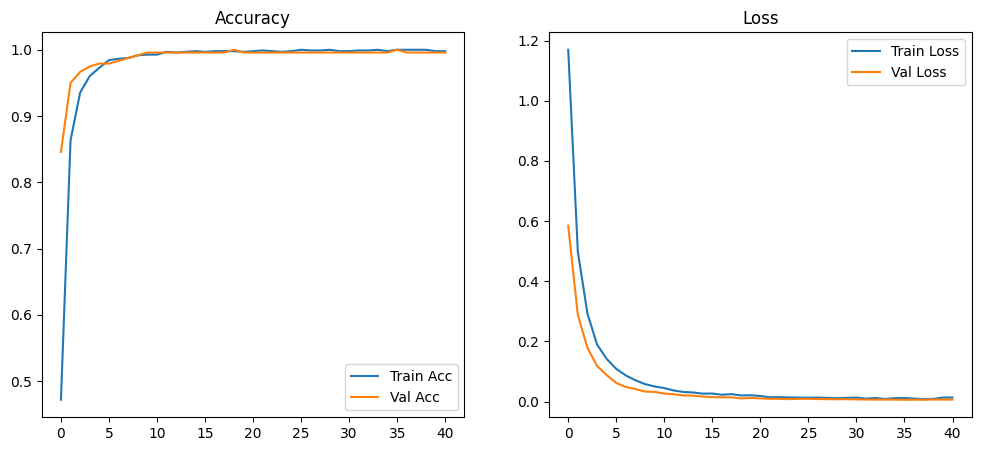

In [27]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()

***Evaluation with Confusion Matrix***

8/8 ━━━━━━━━━━━━━━━━━━━━ 66s 8s/step


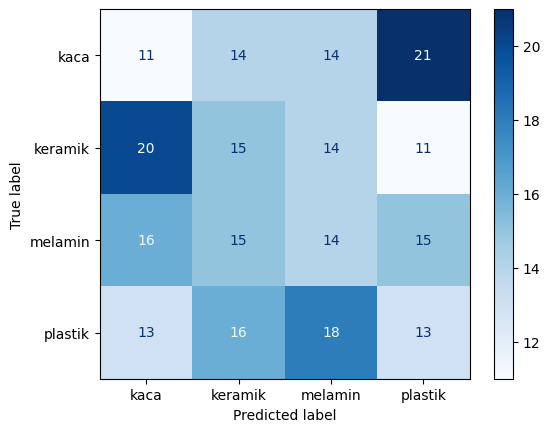

              precision    recall  f1-score   support

        kaca       0.18      0.18      0.18        60
     keramik       0.25      0.25      0.25        60
     melamin       0.23      0.23      0.23        60
     plastik       0.22      0.22      0.22        60

    accuracy                           0.22       240
   macro avg       0.22      0.22      0.22       240
weighted avg       0.22      0.22      0.22       240



In [28]:
val_generator.reset()
y_pred = model.predict(val_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = val_generator.classes

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap='Blues')
plt.show()

print(classification_report(y_true, y_pred_classes, target_names=class_names))

***Predicting on Batch of Validation Data***

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


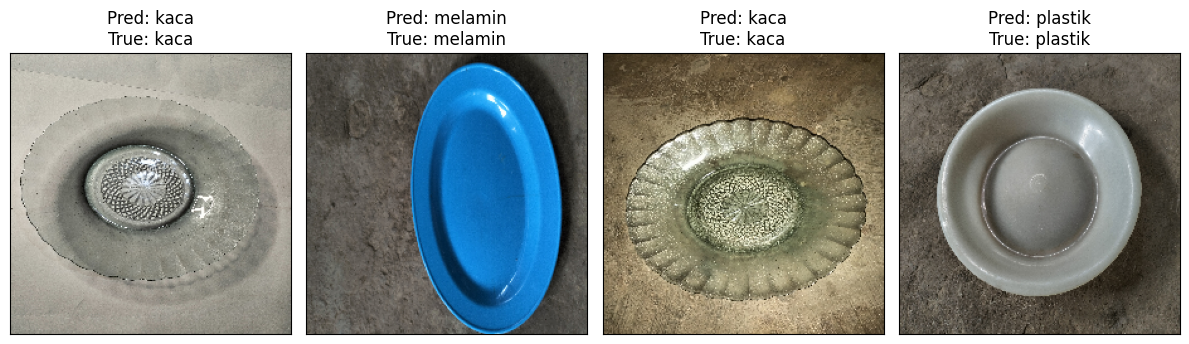

In [45]:
# Ambil batch dari validation set
val_images, val_labels = next(val_generator)

# Prediksi
preds = model.predict(val_images)
pred_classes = np.argmax(preds, axis=1)
true_classes = np.argmax(val_labels, axis=1)

# Tampilkan 4 gambar pertama dari batch
fig = plt.figure(figsize=(12, 6))
for idx in range(4):
    ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
    img = val_images[idx]
    ax.imshow(img)
    pred_label = class_names[pred_classes[idx]]
    true_label = class_names[true_classes[idx]]
    ax.set_title(f"Pred: {pred_label}\nTrue: {true_label}")
plt.tight_layout()
plt.show()

***Grad-CAM Visualization***

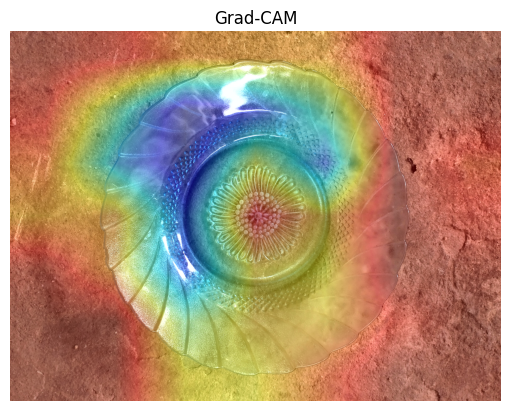

In [51]:
!pip install opencv-python
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

# ... (Your existing code) ...

def display_gradcam(img_path, model, last_conv_layer_name):
    # Load and preprocess the image
    img = load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)

    # Generate Grad-CAM heatmap
    heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)

    # ... (rest of your display_gradcam function) ...

    # Display the original image and heatmap
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) #Convert to RGB for display
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = heatmap * 0.4 + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8) #Clip values to 0-255

    plt.imshow(superimposed_img) # Display without converting again
    plt.axis('off')
    plt.title('Grad-CAM')
    plt.show()


# Correct the path to match your directory structure.
test_image_path = "/content/data_split/val/kaca/IMG20250424142517.jpg"
display_gradcam(test_image_path, model, 'out_relu')  # Try 'out_relu' or 'block_16_depthwise_relu'